In [1]:
import os
import tensorflow as tf

from modules.run import load_config
from modules.run import Trainer
from modules.data import DataManager
from modules.models import pretrained_cnn, pretrained_cnn_multichannel

## Testing imports

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
config=load_config("cls_cropped_all_peru-final")
data_manager = DataManager(config)


train_generator, val_generator, dataframe = data_manager.generate_peru()
convnet = pretrained_cnn_multichannel(config, image_size=config["image_size"], n_channels=config["n_channels"])
trainer = Trainer(config)

Declouded dataframe length: 97281
Found 85500 validated image filenames belonging to 3 classes.
Found 9500 validated image filenames belonging to 3 classes.


In [ ]:
convnet.compile(loss=trainer.loss, optimizer=trainer.optimizer, weighted_metrics=config["weighted_metrics"])

convnet.fit_generator(
    train_generator, 
    epochs=config["n_epochs"],
    callbacks=trainer.callbacks,
    validation_data=val_generator, 
    validation_steps=len(val_generator),
#     class_weight=data_manager.class_weight("kenya"),
    class_weight=[1.64, 1, 2],
    use_multiprocessing=True
)

Epoch 1/15
  40/2672 [..............................] - ETA: 2:16:04 - loss: 1.1236 - accuracy: 0.4422

In [4]:
convnet.load_weights('data/cls_cropped_all_peru-2/checkpoints/weights.02-0.79.hdf5')
# convnet.load_weights('data/cls_cropped_Xception_all-2/checkpoints/weights.03-0.49.hdf5')
# predictions = convnet.predict_generator(val_generator, steps=len(val_generator))
# predictions = np.argmax(predictions, axis=1)

In [8]:
len([i for i, x in enumerate(val_generator.classes) if x == 2])

929

In [ ]:
from sklearn.metrics import confusion_matrix

major_indices = [i for i, x in enumerate(val_generator.classes) if x == 0][:495]
minor_indices = [i for i, x in enumerate(val_generator.classes) if x == 1][:495]
two_indices = [i for i, x in enumerate(val_generator.classes) if x == 2][:495]

y_pred = []
y_true = []

for index in major_indices:
    y_true.append(val_generator.classes[index])
    y_pred.append(predictions[index])
    
for index in minor_indices:
    y_true.append(val_generator.classes[index])
    y_pred.append(predictions[index])
    
for index in two_indices:
    y_true.append(val_generator.classes[index])
    y_pred.append(predictions[index])

# y_pred = np.argmax(predictions, axis=1)

print(np.sum(np.array(y_true) == np.array(y_pred)))

classes = ['Major', 'Minor', 'Two-Track']

cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=classes, yticklabels=classes,
       title='Peru - Xception Cropped - Declouded',
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# fmt = '.2f' if normalize else 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

fig.tight_layout()
fig.show()
plt.ylim([2.5, -0.5])

In [5]:
p_config=load_config("cls_cropped_Xception_all-2")
p_data_manager = DataManager(p_config)
p_train_generator, p_val_generator, p_dataframe = p_data_manager.generate_kenya()

Declouded dataframe length: 152505
Found 135000 validated image filenames belonging to 3 classes.
Found 15000 validated image filenames belonging to 3 classes.


In [13]:
p_predictions = convnet.predict_generator(p_val_generator, steps=len(p_val_generator))
p_predictions = np.argmax(p_predictions, axis=1)

495
495
495
859


(2.5, -0.5)

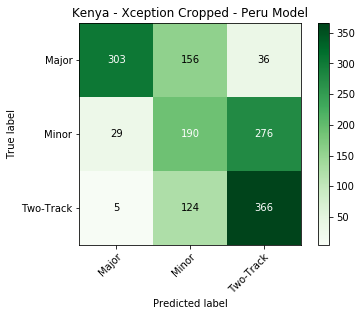

In [14]:
major_indices = [i for i, x in enumerate(p_val_generator.classes) if x == 0][:495]
minor_indices = [i for i, x in enumerate(p_val_generator.classes) if x == 1][:495]
two_indices = [i for i, x in enumerate(p_val_generator.classes) if x == 2][:495]

print(len(major_indices))
print(len(minor_indices))
print(len(two_indices))

y_pred = []
y_true = []

for index in major_indices:
    y_true.append(p_val_generator.classes[index])
    y_pred.append(p_predictions[index])
    
for index in minor_indices:
    y_true.append(p_val_generator.classes[index])
    y_pred.append(p_predictions[index])
    
for index in two_indices:
    y_true.append(p_val_generator.classes[index])
    y_pred.append(p_predictions[index])

# y_pred = np.argmax(predictions, axis=1)

print(np.sum(np.array(y_true) == np.array(y_pred)))

classes = ['Major', 'Minor', 'Two-Track']

cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=classes, yticklabels=classes,
       title='Kenya - Xception Cropped - Peru Model',
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# fmt = '.2f' if normalize else 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

fig.tight_layout()
fig.show()
plt.ylim([2.5, -0.5])

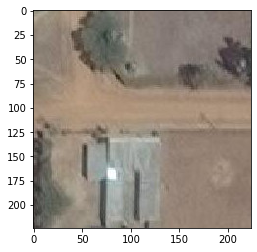

[2]
[1]


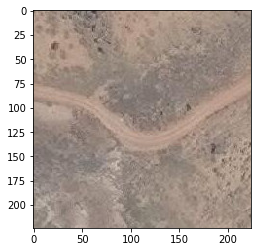

In [37]:
from PIL import Image
minor = dataframe['filename'][dataframe['class'] == 'two-track'].sample(1000, replace=False)
p_minor = p_dataframe['filename'][p_dataframe['class'] == 'minor'].sample(5, replace=False)
p_two = p_dataframe['filename'][p_dataframe['class'] == 'two-track'].sample(5, replace=False)
# print(minor)
# print(p_major)
# print(p_two)
from tensorflow.keras.applications.xception import preprocess_input

os.listdir()

filename="50733_232619.jpg"

minor = minor.reset_index()
p_minor = p_minor.reset_index()
p_two = p_two.reset_index()

img_size = 224
i = 0
while i < 1000:
    try:
        filename = p_minor[i:i+1]['filename'][0]
        cropped_image = Image.open('data/kenya/224/cropped/' + filename)
        break
    except:
        i+=1
cropped_image = cropped_image.resize((img_size, img_size))
cropped_image = np.asarray(cropped_image)
plt.imshow(cropped_image)
plt.show()

preprocessed_image = preprocess_input(cropped_image)
preprocessed_image = np.expand_dims(preprocessed_image, axis=0)
print([np.argmax(convnet.predict(preprocessed_image))])

filename = minor[0:1]['filename'][0]
img_size = 224

cropped_image = Image.open('data/peru/224/cropped/' + filename)
cropped_image = cropped_image.resize((img_size, img_size))
cropped_image = np.asarray(cropped_image)
plt.imshow(cropped_image)

preprocessed_image = preprocess_input(cropped_image)
preprocessed_image = np.expand_dims(preprocessed_image, axis=0)
print([np.argmax(convnet.predict(preprocessed_image))])